## Imports

In [1]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from itertools import product
import configparser
from dataclasses import dataclass
from typing import Iterator, Sequence, Callable
from matplotlib import pyplot as plt
from shapely import Polygon, Point
import shapely as spl
from bbtoolkit.data import Copyable
from bbtoolkit.data.configparser import EvalConfigParser
from shapely.validation import explain_validity
import shapely.prepared as splp
from scipy.spatial import distance
from bbtoolkit.data import WritablePickle


In [2]:
@dataclass
class Texture(Copyable):
    """
    A data class to represent a Texture.

    Attributes:
        id_ (int): The unique identifier for the texture. Default is -1.
        color (str): The color of the texture. Default is None.
        name (str): The name of the texture. Default is None.
    """
    id_: int = -1
    color: str = None
    name: str = None

    def __post_init__(self):
        """
        Post-initialization method to validate the id_ attribute.

        Raises:
            ValueError: if id_ is 0.
        """
        if self.id_ == 0:
            raise ValueError('Texture ID cannot be 0.')


from typing import Any


class Proxy:
    """
    A class that acts as a proxy for another object, allowing controlled access to its attributes.

    Attributes:
        obj (Any): The object being proxied.
    """
    def __init__(self, obj: Any, **kwargs):
        """
        Initializes the Proxy with the object and any additional attributes.

        Args:
            obj (Any): The object to be proxied.
            **kwargs: Additional attributes to be set on the Proxy.
        """
        self.__scope = list(kwargs.keys()) + [
            '__dict__',
            '__class__',
            '__setattr__',
            '__getattribute__',
            '__getattr__',
            'obj',
            'collect_magic',
            '_Proxy__scope'
        ]
        self.obj = obj

        for key, value in kwargs.items():
            self.__setattr__(key, value)

    def collect_magic(self):
        """
        Collects all magic methods from the proxied object that are not in the scope of the Proxy.

        Returns:
            dict: A dictionary of all the collected magic methods.
        """
        attributes = dir(self.obj)
        __dict__ = dict()
        for attr in attributes:
            if attr.startswith('__') and attr.endswith('__') and attr not in self.__scope:
                __dict__[attr] = getattr(self.obj, attr)
            try:
                __dict__[attr] = getattr(self.obj, attr)
            except:
                raise AttributeError(
                    f'Attribute {attr} cannot be accessed.\n'
                    f'The following error occurred:\n\n{sys.exc_info()[0]}'
                )
        return __dict__

    def __getattr__(self, __name: str) -> Any:
        """
        Overrides the default behavior for attribute access. If the attribute is not in the Proxy's scope,
        it returns the attribute from the proxied object. Otherwise, it returns the attribute from the Proxy.

        Args:
            __name (str): The name of the attribute.

        Returns:
            Any: The value of the attribute.
        """
        if __name not in self.__scope:
            return getattr(self.obj, __name)
        else:
            return self.__dict__[__name]

    def __setattr__(self, __name: str, __value: Any) -> None:
        """
        Overrides the default behavior for setting an attribute. If the attribute is in the Proxy's scope,
        it sets the attribute on the Proxy. Otherwise, it sets the attribute on the proxied object.

        Args:
            __name (str): The name of the attribute.
            __value (Any): The value to set the attribute to.
        """
        if __name == '_Proxy__scope' or __name in self.__scope:
            super().__setattr__(__name, __value)
        else:
            setattr(self.obj, __name, __value)


class TexuredPolygon(Proxy):
    """
    A class representing a textured polygon, inheriting from the Proxy class.

    Attributes:
        shell (Sequence | Polygon): The outer boundary of the polygon or a Polygon instance to transform into TexturedPolygon.
        holes (Sequence[Sequence], optional): The holes within the polygon. Default is None.
        texture (Texture, optional): The texture of the polygon. Default is None.
    """
    def __init__(self, shell: Sequence | Polygon, holes: Sequence[Sequence] = None, texture: Texture = None):
        if not isinstance(shell, Polygon):
            polygon = Polygon(shell, holes)
        elif isinstance(shell, Polygon):
            if holes is not None:
                raise ValueError('Cannot specify holes for a Polygon object.')
            polygon = shell
        else:
            raise ValueError(f'Invalid shell type: {type(shell)}')

        texture = texture if texture is not None else Texture()
        super().__init__(polygon, texture=texture)


def plot_polygon(polygon: TexuredPolygon, ax: plt.Axes = None, **kwargs) -> plt.Figure:
    """
    Plots a given polygon on a matplotlib figure.

    Args:
        polygon (TexuredPolygon): The polygon to be plotted.
        ax (plt.Axes, optional): The axes object to draw the plot onto. If None, a new figure and axes object are created. Defaults to None.
        **kwargs: Arbitrary keyword arguments to be passed to the plot function.

    Returns:
        plt.Figure: The figure object with the plotted polygon.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    if isinstance(polygon, TexuredPolygon) and polygon.texture.color is not None:
        kwargs.setdefault('color', polygon.texture.color)
    else:
        kwargs.setdefault('color', 'tab:red')

    ax.plot(*polygon.exterior.xy, **kwargs)

    if polygon.interiors:
        for interior in polygon.interiors:
            ax.plot(*interior.xy, **kwargs)

    return fig


class EnvironmentBuilder(Copyable):
    """
    A class for building environments, defining training areas, objects, and creating configurations.

    Attributes:
        xy_min (float): Minimum value for X and Y axes of the environment.
        xy_max (float): Maximum value for X and Y axes of the environment.
        xy_train_min (float | tuple[float, float]): Minimum training area coordinates for X and Y (default is None).
        xy_train_max (float | tuple[float, float]): Maximum training area coordinates for X and Y (default is None).
        res (float): The resolution used for processing geometry data (default is 0.3).

    Methods:
        to_config(self) -> configparser.ConfigParser: Convert the environment configuration to a ConfigParser object.
        save(self, path: str): Save the environment configuration to a file at the specified path.
        load(cls, path: str) -> 'EnvironmentBuilder': Load an environment configuration from a file.
        add_object(self, *args: Object2D) -> 'EnvironmentBuilder': Add objects to the environment.
        plot(self, show: bool = False) -> plt.Figure: Plot the environment.

    Example:
        >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, res=0.5)
        >>> builder.set_textures(5).set_polygons(8)
        >>> builder.add_object(Object2D(x=(0, 1, 1, 0), y=(0, 0, 1, 1)))
        >>> fig = builder.plot(show=True)
    """
    def __init__(
        self,
        xy_min: float,
        xy_max: float,
        xy_train_min: float | tuple[float, float] = None,
        xy_train_max: float | tuple[float, float] = None,
        res: float =  0.3,
    ) -> None:
        # Initialize the EnvironmentBuilder with specified configurations
        self.xy_min = xy_min
        self.xy_max = xy_max

        if xy_train_max is None:
            self.x_train_max, self.y_train_max = self.xy_max, self.xy_max
        elif isinstance(xy_train_max, float):
            self.x_train_max, self.y_train_max = xy_train_max, xy_train_max
        else:
            self.x_train_max, self.y_train_max = xy_train_max
        if xy_train_min is None:
            self.x_train_min, self.y_train_min = self.xy_min, self.xy_min
        elif isinstance(xy_train_min, float):
            self.x_train_min, self.y_train_min = xy_train_min, xy_train_min
        else:
            self.x_train_min, self.y_train_min = xy_train_min

        self.res = res
        self.objects = list()
        self.walls = list()

    def to_config(self) -> configparser.ConfigParser:
        """
        Generate a configuration parser instance containing environmental information.

        Returns:
            configparser.ConfigParser: Configuration parser instance representing the environmental boundaries,
            training area, building boundaries, and object vertices.

        The generated configuration contains sections representing different aspects of the environment:
        - 'ExternalSources': Empty sections for paths and variables.
        - 'GridBoundaries': Contains maximum and minimum XY coordinate and resolution details.
        - 'TrainingRectangle': Describes the training area coordinates.
        - 'BuildingBoundaries': Holds the maximum number of object points, number of objects, and
          counts of polygons and textures in the environment.

        The object-specific information is stored under individual sections 'Object{i}' for each object.
        Each object section contains 'n_vertices' and 'object_x'/'object_y' detailing the object's vertices.
        """
        parser = EvalConfigParser()
        parser.add_section('ExternalSources')
        parser.set('ExternalSources', 'paths', '')
        parser.set('ExternalSources', 'variables', '')

        parser.add_section('GridBoundaries')
        parser.set('GridBoundaries', 'max_xy', str(self.xy_max))
        parser.set('GridBoundaries', 'min_xy', str(self.xy_min))
        parser.set('GridBoundaries', 'res', str(self.res))

        parser.add_section('TrainingRectangle')
        parser.set('TrainingRectangle', 'min_train_x', str(self.x_train_min))
        parser.set('TrainingRectangle', 'min_train_y', str(self.y_train_min))
        parser.set('TrainingRectangle', 'max_train_x', str(self.x_train_max))
        parser.set('TrainingRectangle', 'max_train_y', str(self.y_train_max))

        parser.add_section('BuildingBoundaries')
        parser.set('BuildingBoundaries', 'max_n_obj_points', str(max([len(obj.exterior.xy[0]) for obj in self.objects])))
        parser.set('BuildingBoundaries', 'n_objects', str(len(self.objects)))

        for i, obj in enumerate(self.objects):
            parser.add_section(f'Object{i+1}')
            parser.set(f'Object{i+1}', 'n_vertices', str(len(obj.exterior.xy[0])))
            parser.set(f'Object{i+1}', 'coords_x', str(obj.exterior.xy[0].tolist())[1:-1])
            parser.set(f'Object{i+1}', 'coords_y', str(obj.exterior.xy[1].tolist())[1:-1])
            parser.set(f'Object{i+1}', 'texture_id', str(obj.texture.id_))
            parser.set(f'Object{i+1}', 'texture_color', str(obj.texture.color))
            parser.set(f'Object{i+1}', 'texture_name', str(obj.texture.name))

        parser.set('BuildingBoundaries', 'n_walls', str(len(self.walls)))

        for i, obj in enumerate(self.walls):
            parser.add_section(f'Wall{i+1}')
            parser.set(f'Wall{i+1}', 'n_vertices', str(len(obj.exterior.xy[0])))
            parser.set(f'Wall{i+1}', 'coords_x', str(obj.exterior.xy[0].tolist())[1:-1])
            parser.set(f'Wall{i+1}', 'coords_y', str(obj.exterior.xy[1].tolist())[1:-1])
            parser.set(f'Wall{i+1}', 'texture_id', str(obj.texture.id_))
            parser.set(f'Wall{i+1}', 'texture_color', str(obj.texture.color))
            parser.set(f'Wall{i+1}', 'texture_name', str(obj.texture.name))

        return parser

    def save(self, path: str):
        """
        Save the generated environment configuration to a specified .ini file.

        Args:
            path (str): The file path to which the configuration will be saved.

        This method uses the `to_config` method to generate the environment configuration and then writes
        it to a file specified by the 'path' argument.
        """
        config = self.to_config()

        with open(path, 'w') as f:
            config.write(f)

    @staticmethod
    def load(path: str) -> 'EnvironmentBuilder':
        """
        Load an environment configuration from a specified .ini file and create an `EnvironmentBuilder` instance.

        Args:
            path (str): The file path from which the environment configuration will be loaded.

        This method loads the configuration stored in the file specified by the 'path' argument. The loaded
        configuration includes details of the grid boundaries, training rectangle, objects, and building boundaries.
        It then uses this loaded information to create an `EnvironmentBuilder` instance.

        Returns:
            EnvironmentBuilder: An `EnvironmentBuilder` instance with the loaded environment configuration.

        Example:
            >>> builder = EnvironmentBuilder.load('environment_config.ini')
            >>> # The builder variable now contains an `EnvironmentBuilder` instance with the loaded configuration.
        """
        config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        config.read(path)
        return EnvironmentBuilder(
            config['GridBoundaries'].eval('min_xy'),
            config['GridBoundaries'].eval('max_xy'),
            (
                config['TrainingRectangle'].eval('min_train_x'),
                config['TrainingRectangle'].eval('min_train_y')
            ),
            (
                config['TrainingRectangle'].eval('max_train_x'),
                config['TrainingRectangle'].eval('max_train_y')
            ),
            config['GridBoundaries'].eval('res')
        ).add_wall(
            *[
                TexuredPolygon(
                    (
                        Point(x, y)
                        for x, y in zip(
                            config[f'Wall{i}'].eval('coords_x'),
                            config[f'Wall{i}'].eval('coords_y')
                        )
                    ),
                    texture=Texture(
                        config[f'Wall{i}'].eval('texture_id'),
                        config[f'Wall{i}'].eval('texture_color'),
                        config[f'Wall{i}'].eval('texture_name')
                    )
                )
                for i in range(1, config['BuildingBoundaries'].eval('n_objects')+1)
            ]
        ).add_object(
            *[
                TexuredPolygon(
                    (
                        Point(x, y)
                        for x, y in zip(
                            config[f'Object{i}'].eval('coords_x'),
                            config[f'Object{i}'].eval('coords_y')
                        )
                    ),
                    texture=Texture(
                        config[f'Object{i}'].eval('texture_id'),
                        config[f'Object{i}'].eval('texture_color'),
                        config[f'Object{i}'].eval('texture_name')
                    )
                )
                for i in range(1, config['BuildingBoundaries'].eval('n_walls')+1)
            ]
        )

    def __validate_objects(self, *objects: Polygon | TexuredPolygon) -> None:
        for object_ in objects:
            if not object_.is_valid:
                raise ValueError(f'Object {object_} is not valid: {explain_validity(object_)}')

    def __validate_textures(self, *objects: Polygon | TexuredPolygon) -> list[TexuredPolygon]:
        out = list()
        for obj in objects:
            if isinstance(obj, TexuredPolygon):
                out.append(obj)
            else:
                out.append(TexuredPolygon(obj))

        return out

    def add_object(self, *args: Polygon | TexuredPolygon) -> 'EnvironmentBuilder':
        """
        Add one or multiple objects to the environment being constructed.

        Args:
            *args (Polygon | TexuredPolygon): Variable number of objects to be added to the environment.

        This method appends one or more objects to the list of objects within the environment being built.
        Each object contain details such as texture and coordinates of the geometric objects present
        within the environment.

        Returns:
            EnvironmentBuilder: The updated instance of the EnvironmentBuilder with the added objects.
        """
        self.__validate_objects(*args)
        self.objects += list(self.__validate_textures(*args))
        return self

    def add_wall(self, *args: Polygon | TexuredPolygon) -> 'EnvironmentBuilder':
        """
        Add one or multiple objects to the environment being constructed.

        Args:
            *args (Polygon | TexuredPolygon): Variable number of objects to be added to the environment.

        This method appends one or more objects to the list of objects within the environment being built.
        Each object contain details such as texture and coordinates of the geometric objects present
        within the environment.

        Returns:
            EnvironmentBuilder: The updated instance of the EnvironmentBuilder with the added objects.
        """
        self.__validate_objects(*args)
        self.walls += list(self.__validate_textures(*args))
        return self

    def remove_object(self, i: int) -> 'EnvironmentBuilder':
        """
        Removes the object at the specified index from the list of objects in the environment.

        Args:
            i (int): The index of the object to be removed.

        Returns:
            EnvironmentBuilder: The modified EnvironmentBuilder object after removing the specified object.
        """
        self.objects.pop(i)
        return self

    def remove_wall(self, i: int) -> 'EnvironmentBuilder':
        """
        Removes the wall at the specified index from the list of objects in the environment.

        Args:
            i (int): The index of the object to be removed.

        Returns:
            EnvironmentBuilder: The modified EnvironmentBuilder object after removing the specified object.
        """
        self.walls.pop(i)
        return self

    def __add__(self, other: 'EnvironmentBuilder') -> 'EnvironmentBuilder':
        """
        Adds the objects and properties of two EnvironmentBuilder instances.

        Merges the objects from two separate EnvironmentBuilder instances into a new instance.
        The new instance retains the original attributes of the first instance (self), such as grid boundaries,
        training rectangle, resolution, and objects. It also appends the objects and updates the properties (textures
        and polygons) as specified.

        Args:
            other (EnvironmentBuilder): Another EnvironmentBuilder instance to be combined with the current one.

        Returns:
            EnvironmentBuilder: A new EnvironmentBuilder instance containing the combined objects and attributes from self and other.
        """
        return EnvironmentBuilder(
            self.xy_min,
            self.xy_max,
            self.x_train_min,
            self.y_train_min,
            self.x_train_max,
            self.y_train_max,
            self.res,
        ).add_object(
            *self.objects,
            *other.objects
        ).add_wall(
            *self.walls,
            *other.walls
        )

    def plot(self, ax: plt.Axes = None) -> plt.Figure:
        """
        Visualizes the environment layout by generating a plot using matplotlib.

        Args:
            ax (plt.Axes, optional): Matplotlib Axes to use for plotting. If None, a new subplot is created. Defaults to None.

        This method generates a plot that visualizes the layout of the environment using matplotlib. It plots the
        boundaries of the entire environment, the training area, and the objects within it.

        Returns:
            plt.Figure: A matplotlib Figure object representing the generated plot.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> fig = builder.plot(show=True)
            >>> # The plot showing the environment layout will be displayed.
        """
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        # plot whole area
        ax.plot(
            (self.xy_min, self.xy_min, self.xy_max, self.xy_max, self.xy_min),
            (self.xy_min, self.xy_max, self.xy_max, self.xy_min, self.xy_min),
            '-', color='#999', label='Whole Area'
        )
        # plot training area
        ax.plot(
            (self.x_train_min, self.x_train_min, self.x_train_max, self.x_train_max, self.x_train_min),
            (self.y_train_min, self.y_train_max, self.y_train_max, self.y_train_min, self.y_train_min),
            '--', color='tab:blue', label='Training Area'
        )

        # plot walls
        for wall in self.walls:
            if wall.texture.color is None:
                plot_polygon(wall, color='tab:orange', ax=ax)
            else:
                plot_polygon(wall, ax=ax)

        # plot objects
        for obj in self.objects:
            plot_polygon(obj, ax=ax)

        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
        ax.grid()

        return fig

In [3]:
def create_cartesian_space(from_: int | tuple[int, ...], to: int | tuple[int, ...], res: float, return_grid: bool = False) -> list[np.ndarray]:
    """
    Function to create an n-dimensional coordinates system in specified ranges.

    Parameters:
    from_ (tuple): Tuple of n dimensions representing boundaries from which grid should start.
    to (tuple): Tuple of n dimensions representing end range of grid in each dimension.
    res (tuple): Tuple representing resolution at each dimension.
    return_grid (bool): If True, returns a list of n-dimensional meshgrids. Othervise returns a list of 1-dimensional arrays representing ordinate vectors. Default is False.

    Returns:
    list: List of n-dimensional meshgrids.
    """
    if isinstance(from_, (int, float)):
        from_ = (from_,)
    if isinstance(to, (int, float)):
        to = (to,)
    if isinstance(res, float):
        res = (res,)*len(from_)
    # Check if the lengths of the input tuples are equal
    if len(from_) != len(to) or len(from_) != len(res):
        raise ValueError("All input parameters must be of the same length.")

    # Create ranges for each dimension
    ranges = [np.arange(from_[i], to[i] + res[i], res[i]) for i in range(len(from_))]


    if return_grid:
        # Create meshgrid
        mesh = np.meshgrid(*ranges, indexing='ij')

        return mesh

    return ranges


def regroup_min_max(*args: tuple[int | float, ...]) -> tuple[tuple[int | float, ...], tuple[int | float, ...]]:
    """
    Function to regroup min and max values for each dimension.

    Args:
        *args: Variable number of tuples of min and max values for each dimension.

    Returns:
        tuple: Tuple of tuples of min values and tuple of tuples of max values for each dimension.
    """
    half = len(args) // 2
    min_values = args[:half]
    max_values = args[half:]
    return min_values, max_values


def create_shapely_points(*vectors: np.ndarray, res: float) -> list[Point]:
    """
    Function to create Shapely points filling a space defined by the given vectors.

    Args:
        *vectors: Variable number of vectors defining the space.
        res (float): Resolution of the space.
    Returns:
        list: List of Shapely points.
    """
    # Generate combinations of coordinates
    coordinates = product(*vectors)

    # Create Shapely points from coordinates
    points = [Point(coord).buffer(res/2) for coord in coordinates] # half resolution to make points to not overlap

    return points


def points2indices(points: np.ndarray, vectors: list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
    """
    Function to create a list of indices of points in the vectors.

    Args:
        points (list): List of Shapely points.
        vectors (list): List of vectors defining the space.

    Returns:
        tuple: Tuple of arrays of indices of points in the vectors.
    """
    # Create a list of indices of points in the vectors
    x_indices = [np.argmin(np.abs(vectors[0] - center[0])) for center in points]
    y_indices = [np.argmin(np.abs(vectors[1] - center[1])) for center in points]

    return np.array(x_indices), np.array(y_indices)


def points2mask(points: np.ndarray, vectors: list[np.ndarray]) -> np.ndarray:
    """
    Function to create a mask from a list of Shapely points.

    Args:
        points (list): List of Shapely points.
        vectors (list): List of vectors defining the space.

    Returns:
        np.ndarray: Mask representing the points.
    """
    x_indices, y_indices = points2indices(points, vectors)

    # Create a mask
    mask = np.zeros((len(vectors[0]), len(vectors[1]))).astype(bool)
    mask[x_indices, y_indices] = True

    return mask

In [4]:
def poly2vectors(poly: Polygon) -> tuple[np.ndarray, np.ndarray]:
    """
    Transforms polygon to points and direction vectors.

    Args:
        poly (Polygon): Polygon to be transformed.

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple containing points and direction vectors.
    """
    exterior_starting_points = np.array(poly.exterior.coords[1:])
    interior_starting_points = [np.array(interior.coords[1:]) for interior in poly.interiors]
    starting_points = np.concatenate([exterior_starting_points, *interior_starting_points])
    directions = np.concatenate([
        poly.exterior.coords[:-1],
        *[interior.coords[:-1] for interior in poly.interiors]
    ]) - starting_points

    return starting_points, directions


def find_closest_points(space1: np.ndarray, space2: np.ndarray) -> np.ndarray:
    """
    Finds the points in space1 that are closest to each point in space2.

    This function computes the Euclidean distance between each point in space1 and each point in space2,
    then finds the index of the minimum distance for each point in space2. It then returns the points in space1
    that correspond to these indices.

    Args:
        space1 (np.ndarray): A 2D numpy array of shape (m, 2) representing m points in a 2D space.
        space2 (np.ndarray): A 2D numpy array of shape (n, 2) representing n points in a 2D space.

    Returns:
        np.ndarray: A 2D numpy array of shape (n, 2) representing the n points in space1 that are closest to each point in space2.

    """
    # Compute the pairwise distances between M and N
    distances = distance.cdist(space1, space2, 'euclidean')

    # Get the indices of the minimum distances in M for each point in N
    min_indices = np.argmin(distances, axis=0)

    # Return the closest points in M for each point in N
    return space1[min_indices]


def matrix2vectors(matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Transforms matrix of polygon coordinates (n_polygons, n_points, 2) to points and direction vectors.

    Args:
        matrix (np.ndarray): Matrix to be transformed.

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple containing points and direction vectors.
    """
    starting_points = matrix[:, 1:, :]
    directions = matrix[:, :-1, :] - starting_points

    return starting_points.reshape(-1, 2), directions.reshape(-1, 2)


In [5]:
def operation3d(a: np.ndarray, b: np.ndarray, operation: Callable[[np.ndarray, np.ndarray], np.ndarray], return_2d: bool = False) -> np.ndarray:
    """
    Operation between two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        operation (Callable[[np.ndarray, np.ndarray], np.ndarray]): Operation to perform on the tensors. (This operation will be performed k times to a and each row of b.)
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    m, n = a.shape
    k, _ = b.shape
    c = operation(a[None, :, :], b[:, None, :])

    if return_2d:
        return c.reshape(-1, c.shape[-1])

    return c.reshape(k, m, n)


def operation3d_batched(a: np.ndarray, b: np.ndarray, operation: Callable[[np.ndarray, np.ndarray], np.ndarray], return_2d: bool = False) -> np.ndarray:
    """
    Operation between two batched 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        operation (Callable[[np.ndarray, np.ndarray], np.ndarray]): Operation to perform on the tensors. (This operation will be performed k times to a and each row of b.)
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    n_batches, m, n = a.shape
    n_batches_, k, _ = b.shape

    if n_batches != n_batches_:
        raise ValueError(f'Number of batches of a ({n_batches}) and b ({n_batches_}) must be equal.')

    c = operation(a[:, None, :, :], b[:, :, None, :])

    if return_2d:
        return c.reshape(n_batches, -1, c.shape[-1])

    return c.reshape(n_batches, k, m, n)


def sub3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Subtracts two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: a - b, return_2d)

def cross3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Cross product of two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: np.cross(a, b), return_2d)

def divide3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Cross product of two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: a / b, return_2d)


def compute_intersection3d(
    point1: np.ndarray,
    point2: np.ndarray,
    direction1: np.ndarray,
    direction2: np.ndarray,
    return_flat: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the intersection points between two lines defined by their starting points and directions.
    Vectorized version of `compute_intersection`. Can compute intersection between n vs m lines. Output is of shape (n, m, 3).

    Args:
        point1 (numpy.ndarray): Starting point of the first line.
        point2 (numpy.ndarray): Starting point of the second line.
        direction1 (numpy.ndarray): Direction vector of the first line.
        direction2 (numpy.ndarray): Direction vector of the second line.
        return_flat (bool): If True, returns flat tensor. Default is False.

    Returns:
        Tuple of two numpy arrays, representing the intersection points:
          - alpha1 (numpy.ndarray): Parameter values indicating the intersection points along the first line.
          - alpha2 (numpy.ndarray): Parameter values indicating the intersection points along the second line.

    """
    batch_first = True if point1.ndim == 3 else False

    denominator_2 = cross3d(direction1, direction2, return_2d=False, batch_first=batch_first)
    denominator_2[denominator_2 == 0] = np.nan
    denominator_1 = -denominator_2

    if batch_first:
        transpose_dims = (0, 2, 1, 3)
    else:
        transpose_dims = (1, 0, 2)

    alpha2 = np.cross(
        sub3d(
            point2,
            point1,
            return_2d=False,
            batch_first=batch_first
        ),
        direction1[:, :, None, :] if batch_first else direction1[:, None, :],
        ).transpose(*transpose_dims)/denominator_2
    alpha1 = np.cross(
        sub3d(
            point1,
            point2,
            return_2d=False,
            batch_first=batch_first
        ),
        direction2[:, :, None, :] if batch_first else direction2[:, None, :],
    )/denominator_1

    alpha1 = alpha1[:, :, :, 2] if batch_first else alpha1[:, :, 2]
    alpha2 = alpha2[:, :, :, 2] if batch_first else alpha2[:, :, 2]

    if return_flat:
        return alpha1.reshape(-1), alpha2.reshape(-1)

    return alpha1, alpha2


In [194]:
from collections import OrderedDict
import hashlib
from typing import Callable

class Cached:
    """
    A class for caching the results of another function with a specified maximum size for the cache.

    Args:
        max_size (int): The maximum size of the cache. If the cache exceeds this size, the oldest entry is evicted.
        cache_storage (OrderedDict): The storage for the cache. If None, a new OrderedDict is created.

    """
    def __init__(self, max_size: int = 100, cache_storage: OrderedDict = None):
        self.max_size = max_size
        self.cache = cache_storage if cache_storage is not None else OrderedDict()

    def encrypt_key(self, func: Callable, *args, **kwargs):
        """
        Helper method to create a unique hash for the parameters.

        Args:
            func (Callable): The function to be cached.
            *args: Positional arguments.
            **kwargs: Keyword arguments.

        Returns:
            str: The MD5 hash of the concatenated string representation of args and kwargs.
        """
        all_kwargs = {**dict(zip(func.__code__.co_varnames, args)), **kwargs}
        key = hashlib.md5(str(all_kwargs).encode()).hexdigest()
        return key

    def __call__(self, func: Callable):
        def wrapper(*args, **kwargs):
            """
            Wrapper function that adds caching functionality to the decorated function.

            Args:
                *args: Positional arguments.
                **kwargs: Keyword arguments.

            Returns:
                Any: The result of the decorated function.
            """
            key = self.encrypt_key(func, *args, **kwargs)

            # Check if the result is already in the cache
            if key in self.cache:
                # Move the key to the end to mark it as the most recently used
                self.cache.move_to_end(key)
                return self.cache[key]

            # Call the function if the result is not in the cache
            result = func(*args, **kwargs)

            # Add the result to the cache
            self.cache[key] = result

            # Check and evict the oldest entry if the cache size exceeds the maximum
            if len(self.cache) > self.max_size:
                self.cache.popitem(last=False)

            return self.cache[key]

        return wrapper


class VisiblePlaneSubset:
    """
    A class that represents a subset of a visible plane in a 3D space.

    Attributes:
        visible_plane (VisiblePlane): The visible plane object that this subset belongs to.
        object_index (int): The index of the object in the visible plane.
    """
    def __init__(
        self,
        visible_plane: 'LazyVisiblePlane',
        object_index: int
    ):
        """
        Constructs all the necessary attributes for the VisiblePlaneSubset object.

        Args:
            visible_plane (VisiblePlane): The visible plane object that this subset belongs to.
            object_index (int): The index of the object in the visible plane.
        """
        self.visible_plane = visible_plane
        self.object_index = object_index

    def __getitem__(self, indices: int | tuple[int, int] | tuple[int, int, int]) -> np.ndarray: # position, points, axis
        """
        Allows the VisiblePlaneSubset object to be indexed.

        Args:
            indices (int | tuple[int, int] | tuple[int, int, int]): The indices to access.

        Returns:
            np.ndarray: The accessed elements.
        """
        if isinstance(indices, tuple):
            position_index = indices[0]
            rest_indices = indices[1:]
        else:
            position_index = indices
            rest_indices = ()

        coords_x = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 0])
        coords_y = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 1])

        return np.concatenate([self.visible_plane(x, y)[self.object_index] for x, y in zip(coords_x, coords_y)])[*rest_indices] # points, axis

    def __len__(self) -> int:
        """
        Returns the number of room points coordinates in the VisiblePlaneSubset.

        Returns:
            int: Number of room points coordinates.
        """
        return len(self.visible_plane.room_points_coordinates)

    def __iter__(self) -> np.ndarray:
        """
        Allows iteration over the VisiblePlaneSubset object.

        Yields:
            np.ndarray: The accessed elements.
        """
        for index in range(len(self)):
            yield self[index]

    @property
    def shape(self) -> tuple[int, ...]:
        """
        Returns the shape of the VisiblePlaneSubset.

        Returns:
            tuple[int, ...]: A tuple representing the shape of the VisiblePlaneSubset.
        """
        return self.visible_plane.room_points_coordinates.shape[0],\
            self.visible_plane.slices[self.object_index].stop - self.visible_plane.slices[self.object_index].start,\
            self.visible_plane.room_points_coordinates.shape[-1]


class LazyVisiblePlane:
    """
    A class that represents a visible plane in a 2D space.

    Attributes:
        room_points_coordinates (np.ndarray): Coordinates of the room points.
        slices (list[slice]): List of slices for boundary points.
        boundary_points (np.ndarray): Coordinates of the boundary points.
        starting_points (np.ndarray): Starting points for the plane.
        directions (np.ndarray): Directions for the plane.
        cache_manager (Cached): Cache manager for the plane.
    """
    def __init__(
        self,
        starting_points: np.ndarray | list[np.ndarray],
        directions: np.ndarray | list[np.ndarray],
        room_points_coordinates: np.ndarray,
        boundary_points_coordinates: list[np.ndarray],
        cache_manager: Cached = None
    ):
        """
        Constructs all the necessary attributes for the LazyVisiblePlane object.

        Args:
            starting_points (np.ndarray | list[np.ndarray]): Starting points for the plane.
            directions (np.ndarray | list[np.ndarray]): Directions for the plane.
            room_points_coordinates (np.ndarray): Coordinates of the room points.
            boundary_points_coordinates (list[np.ndarray]): Coordinates of the boundary points.
            cache_manager (Cached, optional): Cache manager for the plane. Defaults to None.
        """
        self.room_points_coordinates = room_points_coordinates

        cumulative_lengths = np.cumsum([len(boundary) for boundary in boundary_points_coordinates])
        self.slices = [slice(from_, to) for from_, to in zip([0] + list(cumulative_lengths[:-1]), cumulative_lengths)]
        boundary_points = np.concatenate(boundary_points_coordinates)
        self.boundary_points = np.concatenate( # add z coordinate with zeros to local boundary points
            [
                boundary_points,
                np.zeros((*boundary_points.shape[:-1], 1))
            ],
            axis=-1
        )

        starting_points = np.concatenate(starting_points) if isinstance(starting_points, list) else starting_points
        self.starting_points = np.concatenate( # add z coordinate with zeros to local starting points
            [
                starting_points,
                np.zeros((*starting_points.shape[:-1], 1))
            ],
            axis=-1
        )

        directions = np.concatenate(directions) if isinstance(directions, list) else directions
        self.directions = np.concatenate( # add z coordinate with zeros to directions
            [
                directions,
                np.zeros((*directions.shape[:-1], 1))
            ],
            axis=-1
        )
        self.cache_manager = cache_manager if cache_manager is not None else Cached()


    def __call__(
        self,
        coords_x: float,
        coords_y: float
    ) -> list[np.ndarray]:
        """
        Makes the LazyVisiblePlane object callable.

        Args:
            coords_x (float): X coordinate.
            coords_y (float): Y coordinate.

        Returns:
            list[np.ndarray]: List of visible xy coordinates.
        """
        @self.cache_manager
        def nested_call(
            coords_x: float,
            coords_y: float
        ) -> list[np.ndarray]:
            local_starting_points = self.starting_points - np.array([[coords_x, coords_y, 0]])
            local_boundary_points = self.boundary_points - np.array([[coords_x, coords_y, 0]])
            alpha_pt, alpha_occ = compute_intersection3d(
                np.zeros_like(local_boundary_points),
                local_starting_points,
                local_boundary_points,
                self.directions
            )
            mask = ~np.any((alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ < 1) & (alpha_occ > 0), axis=0)
            visible_xy = np.full((len(local_boundary_points), 2), np.nan)

            visible_xy[mask] = self.boundary_points[mask, :2]

            return [
                visible_xy[slice_]
                for slice_ in self.slices
            ]
        return nested_call(coords_x, coords_y)

    def __getitem__(self, index: int) -> VisiblePlaneSubset:
        """
        Allows the LazyVisiblePlane object to be indexed.

        Args:
            index (int): Index of the desired slice.

        Returns:
            VisiblePlaneSubset: A subset of the VisiblePlane.
        """
        return VisiblePlaneSubset(self, index)

    def __len__(self) -> int:
        """
        Returns the number of slices in the LazyVisiblePlane.

        Returns:
            int: Number of slices.
        """
        return len(self.slices)

    def __iter__(self) -> VisiblePlaneSubset:
        """
        Allows iteration over the VisiblePlane object.

        Yields:
            VisiblePlaneSubset: A subset of the LazyVisiblePlane.
        """
        for index in range(len(self)):
            yield VisiblePlaneSubset(self, index)

In [196]:
class PrecomputedVisiblePlane:
    """
    A class representing a visible plane in a 3D space.

    Attributes:
        _data (np.ndarray): The visible coordinates of the plane.
        _slices (list[slice]): The slices for each object in the visible coordinates.
    """
    def __init__(
        self,
        visible_coordinates: np.ndarray, # shape (n_locations, n_boundary_points, 2)
        object_slices: list[slice], # list of slices for each object in visible_coordinates
    ):
        """
        Initializes the VisiblePlane with visible coordinates and object slices.

        Args:
            visible_coordinates (np.ndarray): The visible coordinates of the plane.
                Shape is (n_locations, n_boundary_points, 2).
            object_slices (list[slice]): The slices for each object in the visible coordinates.
        """
        self._data = visible_coordinates
        self._slices = object_slices

    def __getitem__(self, i: int) -> np.ndarray:
        """
        Returns the visible coordinates for the object at the given index.

        Args:
            i (int): The index of the object.

        Returns:
            np.ndarray: The visible coordinates for the object.
        """
        return self._data[:, self._slices[i], :]

    @property
    def data(self) -> np.ndarray:
        """
        Returns the visible coordinates of the plane.

        Returns:
            np.ndarray: The visible coordinates of the plane.
        """
        return self._data

    @property
    def slices(self) -> list[slice]:
        """
        Returns the slices for each object in the visible coordinates.

        Returns:
            list[slice]: The slices for each object.
        """
        return self._slices


class Area(Copyable):
    """
    A class representing an area defined by a polygon and a set of points.

    Attributes:
        polygon (Polygon): The polygon defining the area.
        points (np.ndarray): The set of points within the area.
    """
    def __init__(
        self,
        polygon: Polygon,
        points: np.ndarray = None,
    ):
        """
        Initializes the Area with a polygon and an optional set of points.

        Args:
            polygon (Polygon): The polygon defining the area.
            points (np.ndarray, optional): The set of points within the area. Default is None.
        """
        self._polygon = polygon
        self._points = points

    @property
    def polygon(self) -> TexuredPolygon:
        """
        Returns the polygon defining the area.

        Returns:
            Polygon: The polygon defining the area.
        """
        return self._polygon

    @property
    def points(self) -> np.ndarray:
        """
        Returns the set of points within the area.

        Returns:
            np.ndarray: The set of points within the area.
        """
        return self._points


class Object(Area):
    """
    A class representing a boundary, which is a specific type of area with visible parts.

    Attributes:
        visible_parts (np.ndarray): The visible parts of the boundary.
    """
    def __init__(
        self,
        polygon: TexuredPolygon,
        points: np.ndarray,
        visible_parts: np.ndarray,
        starting_points: np.ndarray,
        directions: np.ndarray
    ):
        """
        Initializes the Boundary with a polygon, a set of points, and visible parts.

        Args:
            polygon (TexuredPolygon): The polygon defining the boundary.
            points (np.ndarray): The set of points within the boundary.
            visible_parts (np.ndarray): The visible parts of the boundary.
            starting_points (np.ndarray): The starting points of the boundary.
            directions (np.ndarray): The directions of the boundary (vertex-wise difference).
        """
        super().__init__(polygon, points)
        self._visible_parts = visible_parts
        self._starting_points = starting_points
        self._directions = directions

    @property
    def visible_parts(self) -> np.ndarray:
        """
        Returns the visible parts of the boundary.

        Returns:
            np.ndarray: The visible parts of the boundary.
        """
        return self._visible_parts

    @property
    def starting_points(self) -> np.ndarray:
        """
        Returns the starting points of the boundary.

        Returns:
            np.ndarray: The starting points of the boundary.
        """
        return self._starting_points

    @property
    def directions(self) -> np.ndarray:
        """
        Returns the directions of the boundary.

        Returns:
            np.ndarray: The directions of the boundary.
        """
        return self._directions


@dataclass
class Environment(WritablePickle):
    """
    A data class representing an environment with a room, visible area, objects, and a visible plane.

    Attributes:
        room (Area): The room in the environment.
        visible_area (Area): The visible area in the environment.
        objects (list[Object]): The list of objects in the environment.
    """
    room: Area
    visible_area: Area
    objects: list[Object]
    walls: list[Object]


class EnvironmentCompiler:
    """
    A class that compiles an environment using an EnvironmentBuilder.

    Attributes:
        builder (EnvironmentBuilder): The builder used to compile the environment.
    """
    def __init__(
        self,
        builder: EnvironmentBuilder,
        visible_plane_compiler: Callable[
            [
                np.ndarray | list[np.ndarray],
                np.ndarray | list[np.ndarray],
                np.ndarray,
                list[np.ndarray]
            ],
            np.ndarray,
        ] = None,
    ):
        """
        Initializes the EnvironmentCompiler with an EnvironmentBuilder.

        Args:
            builder (EnvironmentBuilder): The builder used to compile the environment.
        """
        self._builder = builder
        self._visible_plane_compiler = visible_plane_compiler

    @property
    def builder(self) -> EnvironmentBuilder:
        """
        Returns the builder used to compile the environment.

        Returns:
            EnvironmentBuilder: The builder used to compile the environment.
        """
        return self._builder

    def compile_room_area(self) -> Polygon:
        """
        Compiles the room area boundaries into a Polygon.

        Returns:
            Polygon: The room area.
        """
        return Polygon([
            Point(self.builder.xy_min, self.builder.xy_min),
            Point(self.builder.xy_min, self.builder.xy_max),
            Point(self.builder.xy_max, self.builder.xy_max),
            Point(self.builder.xy_max, self.builder.xy_min)
        ])

    def compile_visible_area(self) -> Polygon:
        """
        Compiles the visible area boundaries into a Polygon.

        Returns:
            Polygon: The visible area.
        """
        return Polygon([
            Point(self.builder.x_train_min, self.builder.y_train_min),
            Point(self.builder.x_train_min, self.builder.y_train_max),
            Point(self.builder.x_train_max, self.builder.y_train_max),
            Point(self.builder.x_train_max, self.builder.y_train_min)
        ])

    def compile_space_points(
        self,
        x_coords: np.ndarray,
        y_coords: np.ndarray
    ):
        """
        Compiles the space points from a range of coordinates.

        Args:
            from_ (tuple[int, int]): The starting coordinates.
            to (tuple[int, int]): The ending coordinates.

        Returns:
            list[Point]: The compiled space points.
        """
        return create_shapely_points(
            x_coords, y_coords,
            res=self.builder.res
        )

    @staticmethod
    def compile_room_points(
        space_points: list[Point],
        objects: list[Polygon]
    ) -> list[Point]:
        """
        Compiles the room points from a list of space points.

        Args:
            space_points (list[Point]): The space points.
            objects (list[Polygon]): The objects.

        Returns:
            list[Point]: The compiled room points.
        """
        prepared = splp.prep(spl.GeometryCollection([poly.obj for poly in objects]))
        return list(filter(prepared.disjoint, space_points))

    @staticmethod
    def compile_visible_area_points(
        room_points: list[Point],
        visible_area: Polygon
    ) -> list[Point]:
        """
        Compiles the visible area points from a list of room points and a visible area.

        Args:
            room_points (list[Point]): The room points.
            visible_area (Polygon): The visible area.

        Returns:
            list[Point]: The compiled visible area points.
        """
        prepared = splp.prep(visible_area)
        return list(filter(prepared.contains, room_points))

    @staticmethod
    def compile_boundary_points(
        space_points: list[Point],
        objects: list[Polygon]
    ) -> list[Point]:
        """
        Compiles the boundary points from a list of space points.

        Args:
            space_points (list[Point]): The space points.

        Returns:
            list[Point]: The compiled boundary points.
        """
        prepared_objects_boundaries = [
            splp.prep(obj.boundary)
            for obj in objects
        ]
        return [
            list(filter(prepared.crosses, space_points))
            for prepared in prepared_objects_boundaries
        ]

    @staticmethod
    def align_objects(
        boundary_points: list[np.ndarray],
        objects: list[Polygon]
    ) -> list[TexuredPolygon]:
        """
        Aligns the object polygons with the resolution of the space grid.

        Args:
            boundary_points (np.ndarray): The boundary points.

        Returns:
            list[TexturedPolygon]: The aligned object boundaries.

        Notes:
            Alignment is done accordingly to the given boundary points. Shapes of resulting objects can be incorrect.
        """
        # points of space are centers of circles of r=0.5*res.
        # These centers sometimes are not consistent with boundaries of original objects.
        # So we need to make correction to be consistent with resolution
        object_matrices_exterior = [
            np.array(obj.exterior.coords.xy).T
            for obj in objects
        ]
        object_matrices_exterior_corrected = [
            find_closest_points(points, object_matrix)
            for object_matrix, points in zip(object_matrices_exterior, boundary_points)
        ]
        object_matrices_interior = [
            [np.array(interior.coords.xy).T for interior in obj.interiors]
            for obj in objects
        ]
        object_matrices_interior_corrected = [
            [
                find_closest_points(points, object_matrix)
                for object_matrix in interior
            ] if interior else None
            for interior, points in zip(object_matrices_interior, boundary_points)
        ]

        return [ # redefine objects according to space grid correction
            TexuredPolygon(
                zip(
                    obj_coords_exterior[:, 0],
                    obj_coords_exterior[:, 1]
                ),
                [
                    zip(hole[:, 0], hole[:, 1])
                    for hole in obj_holes
                ],
                texture=obj.texture
            )
            for obj,
            obj_coords_exterior,
            obj_holes
            in zip(
                objects,
                object_matrices_exterior_corrected,
                object_matrices_interior_corrected
            )
        ]

    @staticmethod
    def compile_visible_plane(
        starting_points: np.ndarray | list[np.ndarray],
        directions: np.ndarray | list[np.ndarray],
        room_points_coordinates: np.ndarray,
        boundary_points_coordinates: list[np.ndarray] # list of boundary points coordinates for each object
    ) -> LazyVisiblePlane | PrecomputedVisiblePlane:
        """
        Compiles the visible plane from starting points, directions, room points coordinates, and boundary points coordinates.

        Args:
            starting_points (np.ndarray): The starting points.
            directions (np.ndarray): The directions.
            room_points_coordinates (np.ndarray): The room points coordinates.
            boundary_points_coordinates (list[np.ndarray]): The boundary points coordinates for each object.

        Returns:
            VisiblePlane | PrecomputedVisiblePlane: The compiled visible plane.
        """
        starting_points = np.concatenate(starting_points) if isinstance(starting_points, list) else starting_points
        directions = np.concatenate(directions) if isinstance(directions, list) else directions
        all_boundary_points_coordinates = np.concatenate(boundary_points_coordinates)

        n_boundary_points = len(all_boundary_points_coordinates)
        n_training_points = len(room_points_coordinates)

        directions = np.concatenate( # add z coordinate with zeros to directions
            [
                directions,
                np.zeros((*directions.shape[:-1], 1))
            ],
            axis=-1
        )
        local_starting_points = sub3d( # each starting point minus each point of room area
            starting_points,
            room_points_coordinates,
            return_2d=False
        )
        local_starting_points = np.concatenate( # add z coordinate with zeros to local starting points
            [
                local_starting_points,
                np.zeros((*local_starting_points.shape[:-1], 1))
            ],
            axis=-1
        )

        local_boundary_points = sub3d( # each boundary point minus each point of room area
            all_boundary_points_coordinates,
            room_points_coordinates,
            return_2d=False
        )
        local_boundary_points = np.concatenate( # add z coordinate with zeros to local boundary points
            [
                local_boundary_points,
                np.zeros((*local_boundary_points.shape[:-1], 1))
            ],
            axis=-1
        )

        alpha_pt, alpha_occ = compute_intersection3d( # compute intersection points between each line and each boundary using cross product
            np.zeros_like(local_boundary_points), # starting point of each line is [0, 0, 0] (egocentric location of agent)
            local_starting_points, # starting points of each line is each point of object relative to egocentric location of agent
            local_boundary_points, # direction of each line is each boundary point relative to egocentric location of agent
            np.repeat(directions[np.newaxis, :, :], n_training_points, axis=0) # direction of each line is distanec from one vertex of an object to another
        )

        mask = ~np.any((alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ < 1) & (alpha_occ > 0), axis=1)

        visible_xy = np.full((n_training_points, n_boundary_points, 2), np.nan)
        for location, location_mask in enumerate(mask):
            visible_xy[location, location_mask] = all_boundary_points_coordinates[location_mask]

        cumulative_lengths = np.cumsum([len(boundary) for boundary in boundary_points_coordinates])
        slices = [slice(from_, to) for from_, to in zip([0] + list(cumulative_lengths[:-1]), cumulative_lengths)]

        return PrecomputedVisiblePlane(visible_xy, slices)

    @staticmethod
    def compile_directions(objects: list[Polygon]) -> tuple[list[np.ndarray], list[np.ndarray]]:
        """
        Compiles the directions from a list of objects.

        Args:
            objects (list[Polygon]): The objects.

        Returns:
            tuple[np.ndarray, np.ndarray]: The compiled directions.
        """
        starting_points, directions = list(), list()
        for obj in objects:
            starting_points_, directions_ = poly2vectors(obj)
            starting_points.append(starting_points_)
            directions.append(directions_)

        return starting_points, directions

    @staticmethod
    def compile_objects(
        space_points: list[Point],
        visible_coordinates: np.ndarray,
        objects: list[Polygon],
        visible_plane_compiler: Callable[
            [
                np.ndarray | list[np.ndarray],
                np.ndarray | list[np.ndarray],
                np.ndarray,
                list[np.ndarray]
            ],
                np.ndarray,
            ] = None
    ):
        boundary_points = EnvironmentCompiler.compile_boundary_points(space_points, objects)
        boundary_points_coordinates = [
            np.array([[point.centroid.xy[0][0], point.centroid.xy[1][0]] for point in boundary_point])
            for boundary_point in boundary_points
        ]
        objects_corrected = EnvironmentCompiler.align_objects(
            boundary_points_coordinates,
            objects
        )

        starting_points, directions = EnvironmentCompiler.compile_directions(objects_corrected)
        visible_plane_compiler = EnvironmentCompiler.compile_visible_plane \
            if visible_plane_compiler is None else visible_plane_compiler
        visible_plane = visible_plane_compiler(
            starting_points,
            directions,
            visible_coordinates,
            boundary_points_coordinates
        )
        return [
            Object(
                obj,
                boundary_points_coordinates[i],
                visible_plane[i],
                starting_points[i],
                directions[i]
            )
            for i, obj in enumerate(objects_corrected)
        ]

    def compile(
        self
    ) -> Environment:
        """
        Compiles the environment.

        Returns:
            Environment: The compiled environment.
        """
        room_area = self.compile_room_area()
        visible_area = self.compile_visible_area()

        x_coords, y_coords = create_cartesian_space(
            *regroup_min_max(*visible_area.bounds),
            self.builder.res
        )

        space_points = self.compile_space_points(
            x_coords, y_coords
        )

        visible_space_points = self.compile_room_points(
            space_points,
            self.builder.walls + self.builder.objects
        )
        visible_space_points_coordinates = np.array([
            [point.centroid.xy[0][0], point.centroid.xy[1][0]]
            for point in visible_space_points
        ])

        visible_objects = self.compile_objects(
            space_points,
            visible_space_points_coordinates,
            self.builder.objects + self.builder.walls,
            self._visible_plane_compiler
        )
        return Environment(
            Area(room_area),
            Area(visible_area, visible_space_points_coordinates),
            visible_objects[:len(self.builder.objects)],
            visible_objects[len(self.builder.objects):]
        )

## Circular environment

### Function to create coordinates for circle-shaped polygon

In [8]:
def create_circular_polygon(center: Point, radius: float, num_points: int = 100):
    """
    Creates a circular polygon with the specified center and radius.

    Args:
        center (Point): The center of the circle.
        radius (float): The radius of the circle.
        num_points (int, optional): The number of points to use for generating the polygon (default is 100).

    Returns:
        Polygon: A polygon representing the circle.
    """
    # Generate points on the circle
    circle_points = [(center.x + np.cos(2 * np.pi / num_points * x) * radius, center.y + np.sin(2 * np.pi / num_points * x) * radius) for x in range(num_points)]

    # Create the Polygon
    circle = Polygon(circle_points)

    return circle

### Create environment

In [242]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)



builder.add_object(
    create_circular_polygon(Point(0, 0), 15, 50) - create_circular_polygon(Point(0, 0), 13, 50)
)

### Make walls

In [243]:
builder.add_wall(
    Polygon([
        Point(-20, -20),
        Point(-20, 20),
        Point(20, 20),
        Point(20, -20)
    ]) - Polygon([
        Point(-17, -17),
        Point(-17, 17),
        Point(17, 17),
        Point(17, -17),
    ])
)

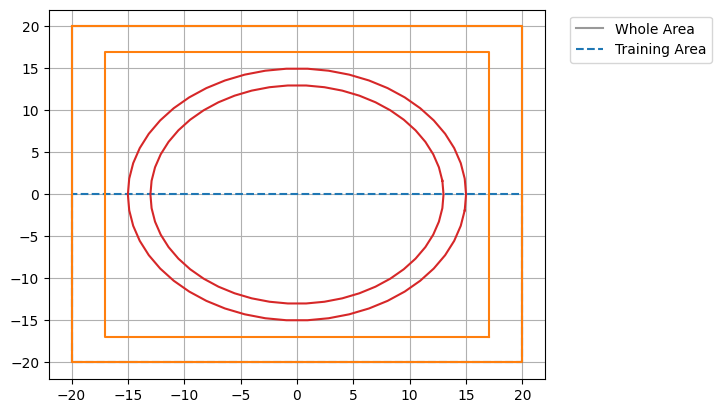

In [244]:
_ = builder.plot()

(5691, 16, 3) (5691, 782, 3) (16, 3)

In [159]:
compiler = EnvironmentCompiler(builder, visible_plane_compiler=VisiblePlane)
env = compiler.compile()

In [136]:
env.save('../data/envs/new_env_dynamic.pkl')

In [ ]:
env = Environment.load('../data/envs/new_env.pkl')

In [121]:
env.objects[0].visible_parts.shape

(5691, 286, 2)

In [116]:
a = (1, 2, 3)
a[1:]

(2, 3)

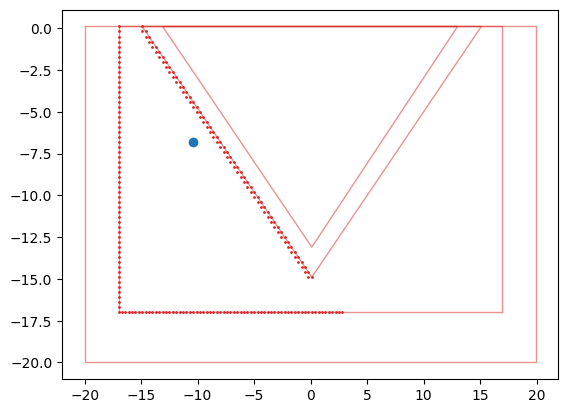

In [160]:
fig, ax = plt.subplots()
position = 1130
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color='tab:red',
        markersize=1
    )

ax.plot(
    env.visible_area.points[position, 0],
    env.visible_area.points[position, 1],
    'o'
)


### Async stuff

In [22]:
import concurrent.futures
import functools
import time

# Define the decorator
def asynchronous(func):
    """
    A decorator that makes a function execute asynchronously.

    This decorator wraps a function and makes it execute in a separate thread.
    The wrapped function is submitted to a ThreadPoolExecutor and its future is returned.

    Args:
        func (callable): The function to be executed asynchronously.

    Returns:
        concurrent.futures.Future: A Future object representing the execution of the function.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        """
        The wrapper function that is called instead of 'func'.

        This function creates a ThreadPoolExecutor, submits 'func' to it for execution,
        and returns the resulting Future object.

        Args:
            *args: Variable length argument list to be passed to 'func'.
            **kwargs: Arbitrary keyword arguments to be passed to 'func'.

        Returns:
            concurrent.futures.Future: A Future object representing the execution of 'func'.
        """
        executor = concurrent.futures.ThreadPoolExecutor()
        future = executor.submit(func, *args, **kwargs)
        return future
    return wrapper

In [617]:
storage = dict()

def update_storage(storage, key, value):
    storage.update({key: value})

@asynchronous
def slow_computation(n):
    time.sleep(0.001)  # Simulate a long running task
    return n

def get_i(i):
    for d in [i, i + 1, i + 2, i + 3, i + 4, i + 5, i + 6, i + 7, i + 8, i + 9]:
        if d not in storage:
            update_storage(storage, d, slow_computation(d))
    return storage[i]


for i in range(100):
    tstart = time.time()
    print(get_i(i).result(), end = '\t')
    # time.sleep(1)
    tend = time.time()
    print(tend - tstart)

0	0.004886627197265625
1	0.0013098716735839844
2	0.0003185272216796875
3	0.00022292137145996094
4	0.00021958351135253906
5	0.00035190582275390625
6	0.0003905296325683594
7	0.00030612945556640625
8	0.0004253387451171875
9	0.00038504600524902344
10	0.0003631114959716797
11	0.0005025863647460938
12	0.00041604042053222656
13	0.0003857612609863281
14	0.0003802776336669922
15	0.00039124488830566406
16	0.0004889965057373047
17	0.0004839897155761719
18	0.0005817413330078125
19	0.0005483627319335938
20	0.00040149688720703125
21	0.0005660057067871094
22	0.0005080699920654297
23	0.0004949569702148438
24	0.0006566047668457031
25	0.0003814697265625
26	0.0002651214599609375
27	0.0003745555877685547
28	0.0002651214599609375
29	0.00028204917907714844
30	0.0003075599670410156
31	0.0003113746643066406
32	0.00019240379333496094
33	0.0003802776336669922
34	0.00030231475830078125
35	0.00026535987854003906
36	0.00027298927307128906
37	0.000530242919921875
38	0.00028324127197265625
39	0.00025963783264160156


In [18]:
from scipy.spatial import KDTree
def get_closest_points_indices(coords: np.ndarray, index: int, tree: KDTree = None, n_points: int = 10) -> dict[str, int]:
    if tree is None:
        tree = KDTree(coords)

    _, indices = tree.query(coords[index], k=n_points)  # Get n closest points (including the point itself)

    return indices

In [147]:
i = 1001
tree = KDTree(env.visible_area.points)
tstart = time.time()
for i in range(1000):
    # print(env.visible_area.points[i])
    # print(env.visible_area.points[list(
    #     set(get_closest_points_indices(env.visible_area.points, i).values())
    # )])
    env.visible_area.points[list(
        set(get_closest_points_indices(env.visible_area.points, i, tree=tree))
    )]
    tend = time.time()
print(tend - tstart)

0.07566165924072266


In [ ]:
class AsyncVisiblePlaneSubset(VisiblePlaneSubset):
    """
    A class that represents an asynchronous subset of a visible plane in a 2D space.

    This class inherits from the VisiblePlaneSubset class and overrides some of its methods
    to provide asynchronous functionality.

    Attributes:
        visible_plane (VisiblePlane): The visible plane object that this subset belongs to.
        object_index (int): The index of the object in the visible plane.
    """
    def __getitem__(self, indices: int | tuple[int, int] | tuple[int, int, int]): # position, points, axis
        if isinstance(indices, tuple):
            position_index = indices[0]
            rest_indices = indices[1:]
        else:
            position_index = indices
            rest_indices = ()

        if isinstance(position_index, (int, np.int32, np.int64)):
            closest_points_indices = set(get_closest_points_indices(
                self.visible_plane.room_points_coordinates,
                position_index,
                tree=self.visible_plane.tree,
                n_points=self.visible_plane.n_neighbours + 1 # + 1 to include the point itself
            )) - {position_index}
            res = self.visible_plane( # validate presence in cache
                self.visible_plane.room_points_coordinates[position_index, 0],
                self.visible_plane.room_points_coordinates[position_index, 1]
            )

            for i in closest_points_indices:
                _ = self.visible_plane( # validate presence in cache
                    self.visible_plane.room_points_coordinates[i, 0],
                    self.visible_plane.room_points_coordinates[i, 1]
                )
            return res.result()[self.object_index][*rest_indices]

        coords_x = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 0])
        coords_y = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 1])

        return np.concatenate([self.visible_plane(x, y).result()[self.object_index] for x, y in zip(coords_x, coords_y)])[*rest_indices] # points, axis

    def __len__(self) -> int:
        """
        Returns the number of room points coordinates in the AsyncVisiblePlaneSubset.

        Returns:
            int: Number of room points coordinates.
        """
        return len(self.visible_plane.room_points_coordinates)

    def __iter__(self) -> np.ndarray:
        """
        Allows iteration over the AsyncVisiblePlaneSubset object.

        Yields:
            np.ndarray: The accessed elements.
        """
        for index in range(len(self)):
            yield self[index]

    @property
    def shape(self) -> tuple[int, ...]:
        """
        Returns the shape of the AsyncVisiblePlaneSubset.

        Returns:
            tuple[int, ...]: A tuple representing the shape of the AsyncVisiblePlaneSubset.
        """
        return self.visible_plane.room_points_coordinates.shape[0],\
            self.visible_plane.slices[self.object_index].stop - self.visible_plane.slices[self.object_index].start,\
            self.visible_plane.room_points_coordinates.shape[-1]


In [245]:
class AsyncVisiblePlaneSubset(VisiblePlaneSubset):
    def __getitem__(self, indices: int | tuple[int, int] | tuple[int, int, int]): # position, points, axis
        # tstart = time.time()
        if isinstance(indices, tuple):
            position_index = indices[0]
            rest_indices = indices[1:]
        else:
            position_index = indices
            rest_indices = ()

        if isinstance(position_index, (int, np.int32, np.int64)):
            # tstart = time.time()
            closest_points_indices = set(get_closest_points_indices(
                self.visible_plane.room_points_coordinates,
                position_index,
                tree=self.visible_plane.tree,
                n_points=self.visible_plane.n_neighbours + 1 # + 1 to include the point itself
            )) - {position_index}
            # print(closest_points_indices)
            # print('register all futures: ', end='\t')
            # tstart = time.time()
            # all_ = list()
            # t1 = time.time()
            res = self.visible_plane( # validate presence in cache
                self.visible_plane.room_points_coordinates[position_index, 0],
                self.visible_plane.room_points_coordinates[position_index, 1]
            )
            # all_.append(time.time() - t1)

            for i in closest_points_indices:
                # t1 = time.time()
                _ = self.visible_plane( # validate presence in cache
                    self.visible_plane.room_points_coordinates[i, 0],
                    self.visible_plane.room_points_coordinates[i, 1]
                )
                # all_.append(time.time() - t1)
            # tend = time.time()
            # print(tend - tstart, f'average: {np.mean(all_)}')

            # print(f'get item: ', end='\t')
            # tstart = time.time()
            # item = res.result()[self.object_index][*rest_indices]
            # tend = time.time()
            # print(tend - tstart)
            # return item
            return res.result()[self.object_index][*rest_indices]

        coords_x = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 0])
        coords_y = np.atleast_1d(self.visible_plane.room_points_coordinates[position_index, 1])

        return np.concatenate([self.visible_plane(x, y).result()[self.object_index] for x, y in zip(coords_x, coords_y)])[*rest_indices] # points, axis

    def __len__(self):
        return len(self.visible_plane.room_points_coordinates)

    def __iter__(self):
        for index in range(len(self)):
            yield self[index]

    @property
    def shape(self):
        return self.visible_plane.room_points_coordinates.shape[0],\
            self.visible_plane.slices[self.object_index].stop - self.visible_plane.slices[self.object_index].start,\
            self.visible_plane.room_points_coordinates.shape[-1]


class AsyncVisiblePlane(LazyVisiblePlane):
    """
    A class that represents a visible plane in a 2D space.

    This class inherits from the LazyisiblePlane class and overrides some of its methods
    to provide lazy asynchronous functionality.

    Attributes:
        n_neighbours (int): The number of neighbours to consider.
        tree (KDTree): The KDTree for efficient nearest neighbour search.
    """
    def __init__(
        self,
        starting_points: np.ndarray | list[np.ndarray],
        directions: np.ndarray | list[np.ndarray],
        room_points_coordinates: np.ndarray,
        boundary_points_coordinates: list[np.ndarray], # list of boundary points coordinates for each object
        cache_manager: Cached = None,
        n_neighbours: int = 10,
    ):
        """
        Constructs all the necessary attributes for the AsyncVisiblePlane object.

        Args:
            starting_points (np.ndarray | list[np.ndarray]): Starting points for the plane.
            directions (np.ndarray | list[np.ndarray]): Directions for the plane.
            room_points_coordinates (np.ndarray): Coordinates of the room points.
            boundary_points_coordinates (list[np.ndarray]): Coordinates of the boundary points.
            cache_manager (Cached, optional): Cache manager for the plane. Defaults to None.
            n_neighbours (int, optional): The number of neighbours to consider. Defaults to 10.
        """
        if cache_manager is None:
            cache_manager = Cached(cache_storage=OrderedDict())

        super().__init__(
            starting_points,
            directions,
            room_points_coordinates,
            boundary_points_coordinates,
            cache_manager
        )
        self.n_neighbours = n_neighbours
        self.tree = KDTree(room_points_coordinates)

    def __call__(
        self,
        coords_x: float,
        coords_y: float
    ) -> list[np.ndarray]:
        """
        Makes the AsyncVisiblePlane object callable.

        Args:
            coords_x (float): X coordinate.
            coords_y (float): Y coordinate.

        Returns:
            list[np.ndarray]: List of visible xy for each object coordinates.
        """
        @self.cache_manager
        @asynchronous
        def nested_call(
            coords_x: float,
            coords_y: float
        ):
            local_starting_points = self.starting_points - np.array([[coords_x, coords_y, 0]])
            local_boundary_points = self.boundary_points - np.array([[coords_x, coords_y, 0]])
            alpha_pt, alpha_occ = compute_intersection3d(
                np.zeros_like(local_boundary_points),
                local_starting_points,
                local_boundary_points,
                self.directions
            )
            mask = ~np.any((alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ < 1) & (alpha_occ > 0), axis=0)
            visible_xy = np.full((len(local_boundary_points), 2), np.nan)

            visible_xy[mask] = self.boundary_points[mask, :2]

            return [
                visible_xy[slice_]
                for slice_ in self.slices
            ]
        return nested_call(coords_x, coords_y)

    def __getitem__(self, index: int) -> AsyncVisiblePlaneSubset:
        """
        Allows the LasyAsyncVisiblePlane object to be indexed.

        Args:
            index (int): Index of the desired slice.

        Returns:
            AsyncVisiblePlaneSubset: An asynchronous subset of the LasyAsyncVisiblePlane.
        """
        return AsyncVisiblePlaneSubset(self, index)


In [346]:
from functools import partial
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = EnvironmentCompiler(
    builder,
    partial(
        AsyncVisiblePlane,
        n_neighbours=10,
        cache_manager=cache_manager,
    )
)
env = compiler.compile()

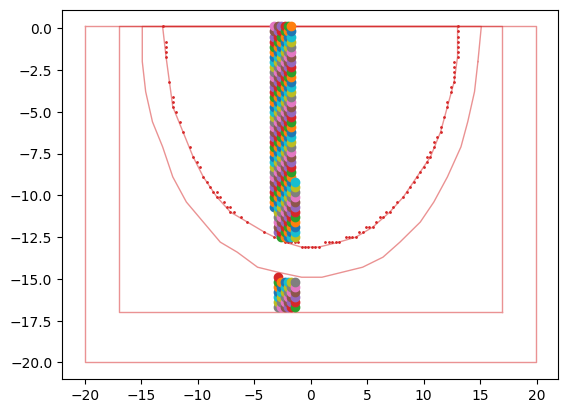

In [330]:
fig, ax = plt.subplots()
position = 2400
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color='tab:red',
        markersize=1
    )

# ax.plot(
#     env.visible_area.points[position, 0],
#     env.visible_area.points[position, 1],
#     'o'
# )
for i in range(2100, 2400):
    ax.plot(
        env.visible_area.points[i, 0],
        env.visible_area.points[i, 1],
        'o'
    )


In [298]:
import random

locations = [100]
counter = 0
while len(locations) <= 500:
    # print(len(locations))
    position_index = locations[-1]

    closest_locations = set(get_closest_points_indices(
        env.objects[0].visible_parts.visible_plane.room_points_coordinates,
        position_index,
        tree=env.objects[0].visible_parts.visible_plane.tree,
        n_points=20#env.objects[0].visible_parts.visible_plane.n_neighbours + 1 # + 1 to include the point itself
    ))

    new_locations = closest_locations - set(locations)
    if not new_locations:
        for _ in range(10):
            locations.pop()
        counter += 1
        if counter > 100:
            break
        continue
    # print(new_locations, locations)
    locations.append(random.choice(list(new_locations)))
    counter = 0

# locations = list(set(locations))

In [164]:
set(get_closest_points_indices(
    env.objects[0].visible_parts.visible_plane.room_points_coordinates,
    position_index,
    tree=env.objects[0].visible_parts.visible_plane.tree,
    n_points=2#env.objects[0].visible_parts.visible_plane.n_neighbours + 1 # + 1 to include the point itself
))

{904, 949}

In [767]:
tstart = time.time()
_ = env.objects[0].visible_parts[0]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.02740955352783203 11


In [768]:
tstart = time.time()
_ = env.objects[0].visible_parts[0]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.0003974437713623047 11


In [770]:
tstart = time.time()
_ = env.objects[0].visible_parts[1]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.0007307529449462891 12


In [771]:
tstart = time.time()
_ = env.objects[0].visible_parts[2]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.004286527633666992 15


In [772]:
tstart = time.time()
_ = env.objects[0].visible_parts[4]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.010893821716308594 20


In [347]:
overall_start = time.time()
log1 = list()
# for i in range(100, 400):
# for i in locations:
for i in range(2100, 2400):
    tstart = time.time()
    _ = env.objects[0].visible_parts[i]
    tend = time.time()
    log1.append(tend - tstart)
    time.sleep(.1)
    print(log1[-1], len(cache_manager.cache))

print(f'Oveall time: {time.time() - overall_start}, average: {np.mean(log1)}')

0.1970078945159912 11
0.00397944450378418 14
0.003045320510864258 18
0.004408836364746094 23
0.0035076141357421875 28
0.003548860549926758 33
0.003167390823364258 37
0.003088235855102539 41
0.004135847091674805 46
0.0028581619262695312 50
0.0014896392822265625 53
0.002523183822631836 57
0.0032417774200439453 62
0.004828691482543945 66
0.002320528030395508 69
0.002475261688232422 73
0.0024421215057373047 77
0.0035936832427978516 82
0.002393960952758789 86
0.0029337406158447266 89
0.002782106399536133 93
0.0032227039337158203 97
0.002921581268310547 102
0.0030786991119384766 106
0.0037877559661865234 111
0.0027704238891601562 115
0.0016887187957763672 118
0.003933906555175781 122
0.0027756690979003906 126
0.007479429244995117 129
0.002645254135131836 133
0.003729104995727539 138
0.002391338348388672 143
0.004808664321899414 147
0.0023109912872314453 151
0.0027222633361816406 156
0.0012598037719726562 158
0.10636115074157715 169
0.0017762184143066406 171
0.0017650127410888672 174
0.002060

In [791]:
tstart = time.time()
_ = env.objects[0].visible_parts[0:100]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.25805020332336426 100


In [ ]:
starting_points = env.objects[0].starting_points
directions = env.objects[0].directions
visible_space_points_coordinates = env.visible_area.points
boundary_points_coordinates = [obj.points for obj in env.objects + env.walls]

vp = LasyAsyncVisiblePlane(
    starting_points,
    directions,
    visible_space_points_coordinates,
    boundary_points_coordinates,
    n_neighbours=1000,
    cache_manager=Cached(cache_storage=OrderedDict(), max_size=10000)
)

In [348]:
from functools import partial
cache_manager = Cached(cache_storage=OrderedDict())
compiler = EnvironmentCompiler(
    builder,
    partial(
        VisiblePlane,
        cache_manager=cache_manager,
    )
)
env = compiler.compile()

In [793]:
tstart = time.time()
_ = env.objects[0].visible_parts[0:100]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.20689129829406738 100


In [710]:
tstart = time.time()
_ = env.objects[0].visible_parts[0]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.0002193450927734375 2


In [707]:
tstart = time.time()
_ = env.objects[0].visible_parts[1]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.0038192272186279297 2


In [712]:
tstart = time.time()
_ = env.objects[0].visible_parts[2]
tend = time.time()
print(tend - tstart, len(cache_manager.cache))

0.0036897659301757812 3


In [349]:
import time

overall_start = time.time()
log2 = list()
# for i in range(100, 400):
# for i in locations:
for i in range(2100, 2400):
    tstart = time.time()
    _ = env.objects[0].visible_parts[i]
    tend = time.time()
    log2.append(tend - tstart)
    time.sleep(.1)
    print(log2[-1], len(cache_manager.cache))

print(f'Oveall time: {time.time() - overall_start}, average: {np.mean(log2)}')

0.01694202423095703 1
0.01467585563659668 2
0.015001296997070312 3
0.015798330307006836 4
0.01584339141845703 5
0.014490127563476562 6
0.011957645416259766 7
0.025171756744384766 8
0.023259401321411133 9
0.020387649536132812 10
0.027403593063354492 11
0.024219512939453125 12
0.023611783981323242 13
0.023094892501831055 14
0.024097442626953125 15
0.0236051082611084 16
0.02442622184753418 17
0.02630758285522461 18
0.026251792907714844 19
0.026202917098999023 20
0.02635335922241211 21
0.02925705909729004 22
0.021162986755371094 23
0.026734352111816406 24
0.02126908302307129 25
0.02804279327392578 26
0.02341318130493164 27
0.026317834854125977 28
0.02294445037841797 29
0.025406837463378906 30
0.0251924991607666 31
0.025617361068725586 32
0.024202823638916016 33
0.02420949935913086 34
0.02875661849975586 35
0.020191669464111328 36
0.01951122283935547 37
0.022305011749267578 38
0.024073362350463867 39
0.022975444793701172 40
0.02463388442993164 41
0.0199124813079834 42
0.02055215835571289 43

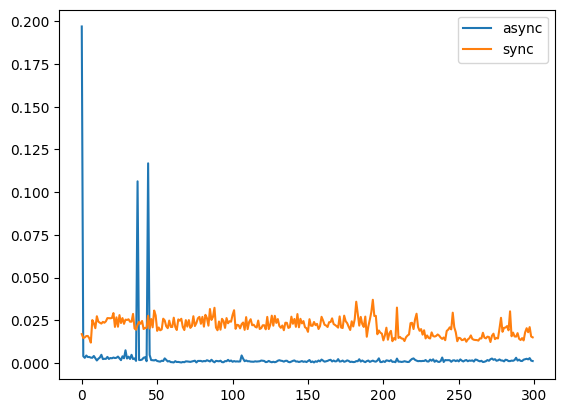

In [350]:
plt.plot(
    log1
)
plt.plot(log2)

plt.legend(['async', 'sync'])
# plt.ylim(0, 0.025)

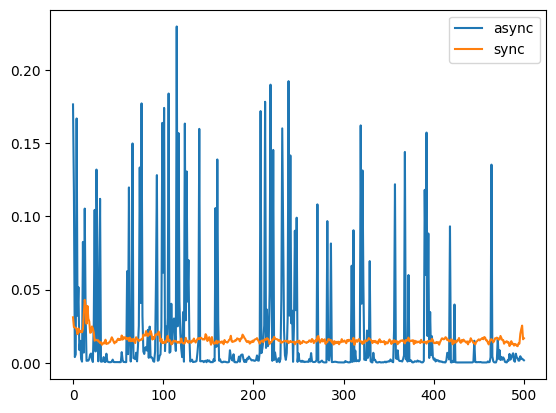

In [283]:
plt.plot(
    log1
)
plt.plot(log2)

plt.legend(['async', 'sync'])

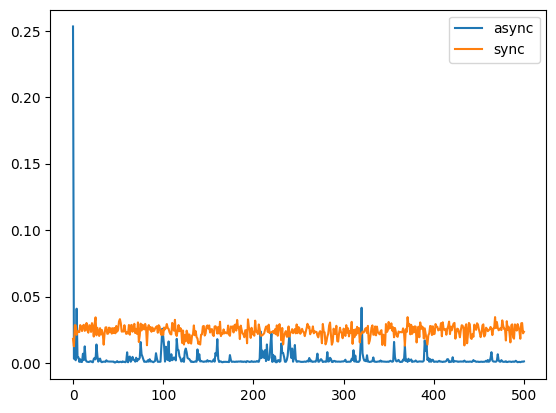

In [278]:
plt.plot(
    log1
)
plt.plot(log2)

plt.legend(['async', 'sync'])

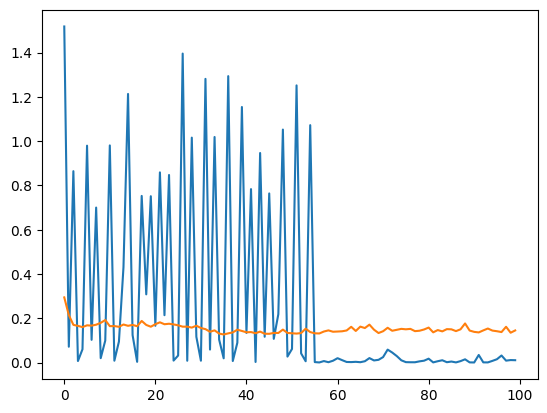

In [53]:
plt.plot(
    log1
)
plt.plot(log2)

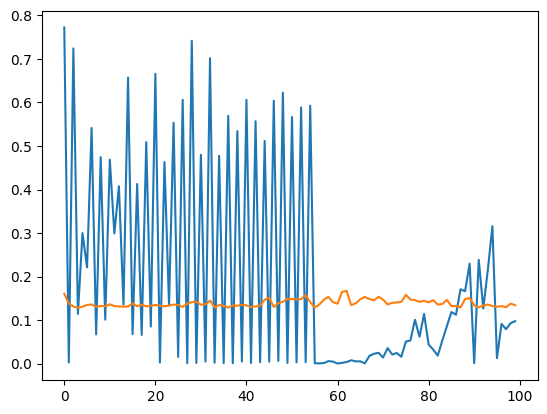

In [61]:
plt.plot(
    log1
)
plt.plot(log2)